##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [43]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import clear_output
import datetime
import itertools
# from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib as mpl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline
%config IPCompleter.greedy=True

import scipy
from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
# from sklearn.externals 
import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from ipywidgets import FloatProgress, HTML

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))

pd.set_option('max_colwidth',200)
MP=True

cwd = os.getcwd()

In [2]:
def Performance(ax,title,target,verbose,lim=None):
    ax.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
            yerr=target.level_best['SE'].values*target.Rule,color='grey',
            alpha = .8,label='Best model at\neach size')
    ax.bar(target.Best['Size'].values,target.Best['MSE'].values,
           yerr=target.Best['SE'].values*target.Rule,
           color='red',alpha = 1,label='Parsimony')
    yaxy = ax.twiny()
    yaxy.bar(target.level_best['Size'].values,target.level_best['MSE'].values,
             yerr=target.level_best['SE'].values*target.Rule,
             color='grey',
             alpha = 0,label=None)
    yaxy.set_xlabel('Number of Factors')
    ax.set_xlabel('Additional Model Input')
    ax.set_title(title,y=1.1,loc='left')
    ax.plot([target.level_best['Size'].min(),target.level_best['Size'].max()],
            [target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule,
            target.Min['MSE'].values[0]+target.Min['SE'].values[0]*target.Rule])
    plt.sca(ax)
    plt.grid()
    if lim is not None:
        ax.set_xlim(lim)
        yaxy.set_xlim(lim)
    
    i=1
    Labs = []
    for mod in target.level_best.Model.unique():
        print(i,mod)
        if i >1:
            Labs.append([val for val in mod.split('+') if val not in modold.split('+')][0])
        else:
            Labs.append(mod)
        modold=mod
        i+=1
    labels = []
    for lab in Labs:
        labels.append(aliases[lab])
    plt.xticks(target.level_best['Size'],labels,rotation=90)
    if verbose>1:
        print(target.Best)
    
def LevelPerformance(ax,title,target,level=1,Rule=1):
    Data = target.Records.loc[target.Records['Size']==level].sort_values('MSE').reset_index()
    
    if level == 1:
        Data['Name']=Data['Model']
        for val in Data['Model']:
            Data.loc[Data['Model']==val,'Name']=aliases[val]
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<=Myax]
        ax.bar(Data['Name'],Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best['Name'],Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',
               alpha = 1,
               label='Parsimony')
        ax.bar(Min['Name'],Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',
               alpha = 1,
               label='Parsimony')
    else:
#         alpha = .025
        Min = Data[Data['MSE']==Data['MSE'].min()]
        Myax = Min['MSE'].values[0]+Min['SE'].values[0]*Rule
        Best = Data[Data['MSE']<= Myax]
        ax.bar(Data.index,Data['MSE'].values,
               yerr=Data['SE'].values*target.Rule,
               color='grey',
            alpha = .8,label='Best model at\neach size')
        ax.bar(Best.index,Best['MSE'].values,
               yerr=Best['SE'].values*target.Rule,
               color='red',alpha = 1,label='Parsimony')
        ax.bar(Min.index,Min['MSE'].values,
               yerr=Min['SE'].values*target.Rule,
               color='blue',alpha = 1,label='Parsimony')
    ax.plot([Data.index[0],Data.index[-1]],[Myax,Myax])
    ax.grid()
    print(Data)

def Mapper(AllData,target,name,Fill=False,DarkTarget=None):
    target.Project(Projector = None,
                Model = None)
    if DarkTarget is None:
        target.RST.Data = AllData
    else:
        target.RST.Data = DarkTarget
    if DarkTarget is None:
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                       ScalePath=target.params['Spath'],Project=True)
    else:
        target.RST.Data = DarkTarget
        target.RST.Scale(target.params['target'],target.params['Inputs'],
                   ScalePath=target.params['Spath'],Project=True,fillTarget = DarkTarget)
    target.Map(Fill)
    AllData[name] = target.Data_Map[target.target].values
#     print(AllData[name])
    AllData[name+'_Var_reg'] = target.Data_Map['Var_reg'].values
    AllData[name+'_Var_er'] = target.Data_Map['Var_er'].values
    AllData[name+'_CI'] = target.Data_Map['CI'].values
    AllData[name+'_PI'] = target.Data_Map['PI'].values
    return(AllData)

def PooledVar_interval(Data,Vars,mean,n): 
    Ux = 1/(Data[Vars].count(axis=0).sum())*(Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)).sum()
    P1 = ((Data[Vars].count(axis=0)-1)*Data[Vars].std(axis=0)**2+Data[Vars].count(axis=0)*Data[Vars].mean(axis=0)**2).sum()
    P2 = Data[Vars].count(axis=0).sum()*Ux**2
    VarX = 1/(Data[Vars].count(axis=0)-1).sum()*(P1-P2)
    SigmaX = (VarX)**.5
    return(SigmaX)


In [3]:
class ResultMap:
    def __init__(self,target,Test='SE',Rule=1,alpha = .025,DataName ='AllData.csv', AltPath=None,Site='FishIsland'):
        self.Rule = Rule
        self.target = target        
        self.params = Dense.Params('Full',self.target,MP)
        self.params['Dpath'] = cwd+'/'+Site+'/'
        self.RST = RSTF.ReadStandardTimeFill(self.params,DataName)
        if AltPath is None:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += target+'/'
        else:
            self.Records = pd.read_csv(self.params['Dpath']+'/'+target+'_'+AltPath+'.csv',delimiter = ',',header = 0,index_col=[0])
            self.params['Dpath'] += AltPath+'/'+target+'/'
            
        self.Records['Model_Key']=self.Records['Size'].astype(str)+'_'+self.Records['Number'].astype(str)
        self.Records['RMSE']=self.Records['MSE']**.5
        self.Min = self.Records.loc[self.Records['MSE']==self.Records['MSE'].min()]
        
        print()
        self.Best = self.Records.loc[self.Records['MSE']<=(self.Min['MSE'].values[0]+self.Min['SE'].values[0]*Rule)]
        self.Best = self.Best.loc[self.Best['Size']==self.Best['Size'].min()]
        self.Best = self.Best.loc[self.Best['MSE']==self.Best['MSE'].min()]
        self.Model_Selection = self.Best.loc[self.Best['MSE'] == self.Best['MSE'].min(), 'Model'].values[0]
            
                
    def Project(self,Projector = None,Model = None):
        if Model ==  None:
            self.Model = self.Model_Selection
        else:
            self.Model = Model
#         print()
        idx = self.Records['Model_Key'].loc[self.Records['Model']==self.Model].values[0]
        self.params['Spath']=(self.params['Dpath']+idx+'/')
        self.params['Inputs'] = self.Model.split('+')
        self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'])
        if Projector != None:
            if Projector['Map'] == None:
                for ip,val in zip(Projector['Assign']['input'],Projector['Assign']['value']):                    
                    self.RST.Data[ip] = val
            else:
                for ip in self.params['Inputs']:
                    self.RST.Data[ip] = self.RST.Data[ip].mean()
                for ip,val in zip(Projector['Map']['input'],Projector['Map']['min'],Projector['Map']['max']):                    
                    self.RST.Data[ip] = val
                
            self.RST.Scale(self.params['target'],self.params['Inputs'],ScalePath=self.params['Spath'],Project=True)
            
    def Map(self,Fill=False,Map=True):
        if Fill == True:
            X = self.RST.X_fill
        else:
            X = self.RST.X
        self.params['Sname']='Y_'
        Y_fill = []
        MSE = []
        prog1 = FloatProgress(min=0, max=self.params['K'],description='Running:')
        display(prog1)
        self.Weights=[]
        if __name__ == "__main__":
            pool = Pool(processes=3,maxtasksperchild=75)
            for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),
                                                 range(self.Best['K'].values[0]))):
                prog1.value+=1
                Y = results[0]
                self.Weights.append(results[1])
#                 print(Y)
                Yold = Y+0
                Y = self.RST.YScaled.inverse_transform(Y)
                if Fill == False and Map == False:
                    mse = (metrics.mean_squared_error(self.RST.y,Y))
                    MSE.append(mse)
                Y_fill.append(Y)
            pool.close()
        Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
        Y_fill_bar = Y_fill.mean(axis=0)
        YTru = self.RST.y+0.0
        if Fill == False and Map == False:
            self.MSE = np.asanyarray(MSE)
            self.CI = stats.t.ppf(1-0.025,k)*self.MSE.std()/(k)**.5
        YStandard = joblib.load(self.params['Spath']+"YVar_scaler.save") 
        self.params['Sname']='Var'
        self.params['Loss']='Boot_Loss'
        
#         pool = Pool(processes=1,maxtasksperchild=75) 
#         for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=self.params),range(0,1))):

        for k in range(0,1):
            results=Dense.Load_Model(k,X=X,params=self.params)
            YVar = results[0]
#             self.Model=results[1]
#             YVar = self.RST.YvarScaled.inverse_transform(YVar)    
            YVar = YStandard.inverse_transform(YVar)                    
#         pool.close()
        X_back = np.squeeze(self.RST.XScaled.inverse_transform(X))
        self.Data_Map = pd.DataFrame(data=X_back,columns=self.params['Inputs'])
        try:
            self.Data_Map['key'] = self.RST.Data['key'].values
        except:
            pass
        self.Data_Map[self.target] = np.squeeze(Y_fill_bar)
        if Map == False:
            self.Data_Map['True'] = YTru
        self.Data_Map['Var_reg'] = 1/(self.params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
        self.Data_Map['Var_er'] = np.squeeze(YVar)
        self.Data_Map['SE'] = self.Data_Map['Var_reg']**.5
        self.T = stats.t.ppf(1-0.025,self.params['K'])
        self.Data_Map['CI']=self.T*self.Data_Map['SE']
        self.Data_Map['PI']=self.T*((self.Data_Map['Var_er']+self.Data_Map['Var_reg'])**.5)
        self.Y_fill = Y_fill
        self.Y_fill_bar = Y_fill_bar
     

## Mapping Alternate

8
                                                                                                                                                                     Model  \
17_0  AirTC_Avg+VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+Temp_2_5_1+Temp_5_1+Temp_15_1+Temp_2_5_2+Temp_5_2+Temp_15_2+Active_Layer_1+u*+wind_speed+air_pressure+Wind_Direction   
8_1                                                                                                 VPD+NR_Wm2_Avg+PPFD_Avg+Table_1+VWC_2+Temp_5_1+Temp_5_2+Active_Layer_1   

           MSE  Size  Number  HiddenNodes        SE        r2  Performance  \
17_0  0.168874    17       0           35  0.037482  0.924835            0   
8_1   0.225201     8       1           17  0.037348  0.899765            0   

        K    Thresh  
17_0  100  0.206356  
8_1   100  0.262549  
           Factors  Key  RC: 17_0  RG: 17_0  SE: 17_0   RC: 8_1   RG: 8_1  \
0        AirTC_Avg    0  0.011067  0.193888  0.013839  0.000000  0.000000   
14      wind_speed  

<IPython.core.display.Javascript object>


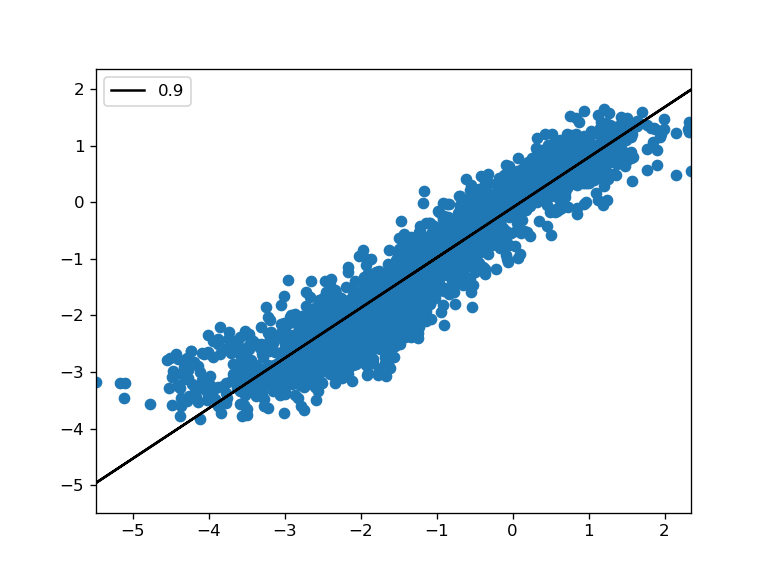

<IPython.core.display.Javascript object>


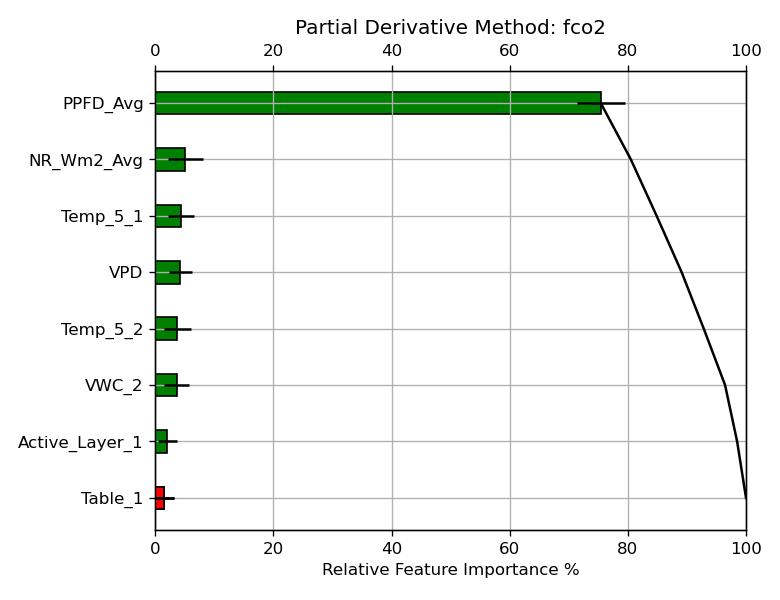

          Factors    Cumsum
0         Table_1  1.000000
1  Active_Layer_1  0.984945
2           VWC_2  0.964525
3        Temp_5_2  0.928422
4             VPD  0.891045
5        Temp_5_1  0.848654
6      NR_Wm2_Avg  0.804992
7        PPFD_Avg  0.753998
['Table_1' 'Active_Layer_1' 'VWC_2' 'Temp_5_2' 'VPD' 'Temp_5_1'
 'NR_Wm2_Avg' 'PPFD_Avg']


In [106]:
# print(fch4.RST.X.shape,T30.shape)
# print(fch4.RST.X_fill.shape)


def RecRead(Path):
    AllRes={}
    for f in ['fco2','fch4']:
        AllRes[f]={}
        AllRes[f]['Records']=pd.read_csv(Path+f+'_Runs.csv',index_col=0)
        AllRes[f]['Results']=pd.read_csv(Path+f+'_Results.csv',index_col=0)
        temp=open(Path+f+'_Removed.txt', "r")
        AllRes[f]['Removed'] = temp.read().split(',')
        AllRes[f]['Derivatives']={}
        AllRes[f]['SSQ'] ={}
        AllRes[f]['X'] = {}
        AllRes[f]['Yhat'] = {}
        AllRes[f]['Ytrue'] = {}
        AllRes[f]['Outputs'] = {}

        for filename in os.listdir(Path):
            if filename.endswith(".npy") and filename.split('.')[0].split('_')[0]==f:
#                 print(filename)
                AllRes[f][filename.split('.')[0].split('_')[1]][int(filename.split('.')[0].split('_')[-1])]=\
                np.load(Path+filename)
    return(AllRes)


def DerivKeys(Resluts,col): 
    i =0
    Keys = {}
    for f,r in zip(Results.Factors.values,Results[col].values):
        if r > 0:
            Keys[f]=i
            i += 1
    return(Keys)
        

AllRes = RecRead(Path = 'C:\\Users\\wesle\\NetworkAnalysis\\FishIsland_Maier/')


F = 'fco2'
SE_Rule=10

Results = AllRes[F]['Results']
Labels = ((Results.set_index('Factors')*-1)**.5+1).fillna(0).sum(axis=1).sort_values(ascending=False).index.values
Records = AllRes[F]['Records']


Min = Records.loc[Records['MSE']==Records['MSE'].min()]
Best = Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*SE_Rule]
Best = Best.loc[Best['Size']==Best['Size'].min()]

N = Best.Size.values[0]
# N = Records.Size.max()
print(N)
print(Records)


Best_U = 'RC: '+Records.loc[Records['Size']==N].index.values[0]
Best_SE = 'SE: '+Records.loc[Records['Size']==N].index.values[0]

print(Results.sort_values(by=Best_U))

print(Results[Best_U].count(),1/Results[Best_U].count())


plt.figure()
# nm=6
y,x = AllRes[F]['Yhat'][N].mean(axis=0),AllRes[F]['Ytrue'][N].mean(axis=0)
slope,intercept,r,p,SE = stats.linregress(x,y)
# print(Op)
plt.scatter(x,y)#(AllRes['fch4'].keys())
plt.plot(x,intercept+slope*x,label=str(np.round(r**2,2)),color='k')
plt.legend()
plt.xlim(x.min(),x.max())
plt.ylim(x.min(),x.max())


Derivatives = AllRes[F]['Derivatives'][N]
Mean = Derivatives.mean(axis=0)
Std = Derivatives.std(axis=0)
X = AllRes[F]['X'][N]

Deriv_Labels= DerivKeys(Results,Best_U)

SubSet = Results.loc[Results[Best_U]>0].sort_values(Best_U,ascending=True).reset_index()

fig,ax=plt.subplots(figsize=(6.5,5))
ax.barh(SubSet.index,SubSet[Best_U]*100,xerr=SubSet[Best_SE]*100,
         height=.4,color='g',edgecolor='k')
No = SubSet.loc[SubSet[Best_U]-SubSet[Best_SE]<0]
ax.barh(No.index,No[Best_U]*100,xerr=No[Best_SE]*100,
         height=.4,color='r',edgecolor='k')
ax2=ax.twiny()
SubSet['Cumsum']=SubSet[Best_U].sort_values(ascending=False).cumsum().sort_values(ascending=False)
ax2.plot(SubSet['Cumsum']*100,SubSet.index,color='k')

print(SubSet[['Factors','Cumsum']])
print(SubSet['Factors'].values)
ax.set_yticks(SubSet.index)
ax.set_yticklabels(SubSet['Factors'].values)

ax.set_xlabel('Relative Feature Importance %')
ax.set_title('Partial Derivative Method: '+F)
ax.grid()
ax.set_xlim(0,100)
# ax.set_xscale('symlog')
ax2.set_xlim(0,100)
plt.tight_layout()

plt.savefig('PAD_'+F+'_PrunedFactors.png')

(100, 10, 2571) (2571, 10)


<IPython.core.display.Javascript object>


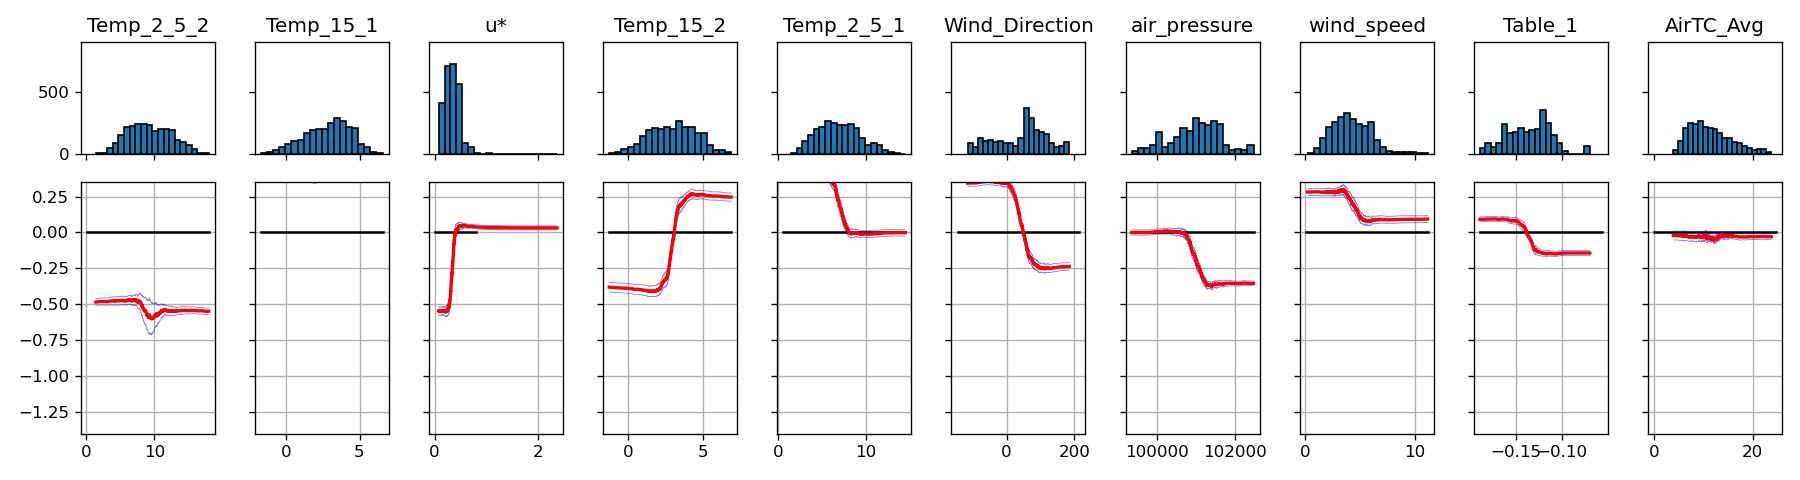

In [97]:
print(Derivatives.shape,X.shape)



Vars = SubSet.sort_values(by='Cumsum')['Factors'].values[:]
gs = fig.add_gridspec(3,len(Vars))
fig = plt.figure(figsize=(len(Vars)*1.5,4))

for j,Var in enumerate(Vars):
    
    i=Deriv_Labels[Var]
    
    ax2 = fig.add_subplot(gs[0:1 , j])
#     T30.hist(ax=ax2,column=Var,bins=10,edgecolor='k')
    plt.hist(X[:,i],bins=20,edgecolor='k')
    ax2.set_ylim(0,900)
    if j != 0:
        
        plt.setp(ax2.get_yticklabels(), visible=False)
    
    
    if j == 0:
        ax1 = fig.add_subplot(gs[1: , j],sharex=ax2)
    else:
        ax1 = fig.add_subplot(gs[1: , j],sharey=ax1,sharex=ax2)
        
        plt.setp(ax1.get_yticklabels(), visible=False)
        
    plt.setp(ax2.get_xticklabels(), visible=False)
    
    

    p = Derivatives.shape[0]
    ax1.plot([T30[Var].min(),T30[Var].max()],[0,0],color='k')
    Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i]+Std[i]/(p**.5)*stats.t.ppf(.0125,p))})#-m)*X[:,i].std()-X[:,i].mean()
    Temp=Temp.sort_values(by='X')
    ax1.plot(Temp['X'],Temp['Y'],color='b',alpha=.5,linewidth=.5)

    Min = Derivatives.min(axis=0)
    Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i]-Std[i]/(p**.5)*stats.t.ppf(.0125,p))})#-m)*X[:,i].std()-X[:,i].mean()
    Temp=Temp.sort_values(by='X')
    ax1.plot(Temp['X'],Temp['Y'],color='b',alpha=.5,linewidth=.5)


    Temp = pd.DataFrame(data={'X':X[:,i],'Y':(Mean[i].flatten())})#-m)*X[:,i].std()-X[:,i].mean()})
    Temp=Temp.sort_values(by='X')
    ax1.plot(Temp['X'],Temp['Y'],color='r',linewidth=2)
    if F!='fco2':
        ax1.set_ylim(-.8,.8)
    else:
        ax1.set_ylim(-1.4,.35)
    ax1.grid()
    ax2.set_title(Var)
    
# plt.show()
plt.tight_layout()

In [73]:

Site='FishIsland'


fch4 = ResultMap('fch4',Test='SE',Rule=SE_Rule,DataName='AllData.csv',Site=Site)#,AltPath='Test')
fco2 = ResultMap('fco2',Test='SE',Rule=SE_Rule,DataName='AllData.csv',Site=Site)#,AltPath='Test')
T30 = fco2.RST.Master.copy()
T30.loc[T30['u*']>.8,'u*']=np.nan
# T30 = Mapper(T30,fch4,'NME_est',Fill = False)
# T30 = Mapper(T30,fco2,'NEE_est',Fill = False)

In [677]:
target = fco2
Name = 'NEE_'
N = 25

IP = target.Model_Selection.split('+')
for a in 'fch4','fco2':
    IP.append(a)
print(IP)

Temp = T30[IP].dropna()
Corr = Temp.corr()
print(Corr)


Avar='PPFD_Avg'
Bvar='VPD'
Cvar='NR_Wm2_Avg'
# Dvar='VPD'

A = np.linspace(Temp[Avar].quantile(0),Temp[Avar].quantile(.99),N)
B = np.linspace(Temp[Bvar].quantile(0),Temp[Bvar].quantile(.99),N)

# C = np.linspace(Temp[Cvar].quantile(0),Temp[Cvar].quantile(1),3)
# Av2,Bv2,Cv2=np.meshgrid(A,B,C)
# Av,Bv,Cv=Av2.flatten(),Bv2.flatten(),Cv2.flatten()

Av2,Bv2=np.meshgrid(A,B)
Av,Bv=Av2.flatten(),Bv2.flatten()

Lr = scipy.stats.linregress(Temp[Avar],Temp[Cvar])
print(Lr)
Cv=Av*Lr[0]+Lr[1]

# Lr = scipy.stats.linregress(Temp[Bvar],Temp[Dvar])
# print(Lr)
# Dv=Bv*Lr[0]+Lr[1]

# Temp = Temp[0:Av.shape[0]]*0+Temp.loc[(Temp['PPFD_Avg']<=10)].mean()
Temp = Temp[0:Av.shape[0]]*0+Temp.median()

Temp[Avar]=Av
Temp[Bvar]=Bv
Temp[Cvar]=Cv
# Temp[Dvar]=Dv

Temp = Mapper(Temp,target,Name,Fill = False)

['VPD', 'NR_Wm2_Avg', 'PPFD_Avg', 'Table_1', 'VWC_2', 'Temp_5_1', 'Temp_5_2', 'Temp_15_2', 'Active_Layer_1', 'wind_speed', 'fch4', 'fco2']
                     VPD  NR_Wm2_Avg  PPFD_Avg   Table_1     VWC_2  Temp_5_1  \
VPD             1.000000    0.572305  0.615305 -0.169321 -0.105669  0.323889   
NR_Wm2_Avg      0.572305    1.000000  0.981322 -0.141769 -0.051461 -0.130880   
PPFD_Avg        0.615305    0.981322  1.000000 -0.180448 -0.070323 -0.100221   
Table_1        -0.169321   -0.141769 -0.180448  1.000000  0.839276 -0.324052   
VWC_2          -0.105669   -0.051461 -0.070323  0.839276  1.000000 -0.329259   
Temp_5_1        0.323889   -0.130880 -0.100221 -0.324052 -0.329259  1.000000   
Temp_5_2        0.561266    0.429394  0.444095 -0.223327 -0.134461  0.761557   
Temp_15_2      -0.358588   -0.645522 -0.660064 -0.048265 -0.265951  0.605977   
Active_Layer_1 -0.111496   -0.195235 -0.228511  0.320383  0.004139  0.077855   
wind_speed      0.087502    0.207429  0.224615  0.008727  0.0

FloatProgress(value=0.0, description='Running:')

<IPython.core.display.Javascript object>


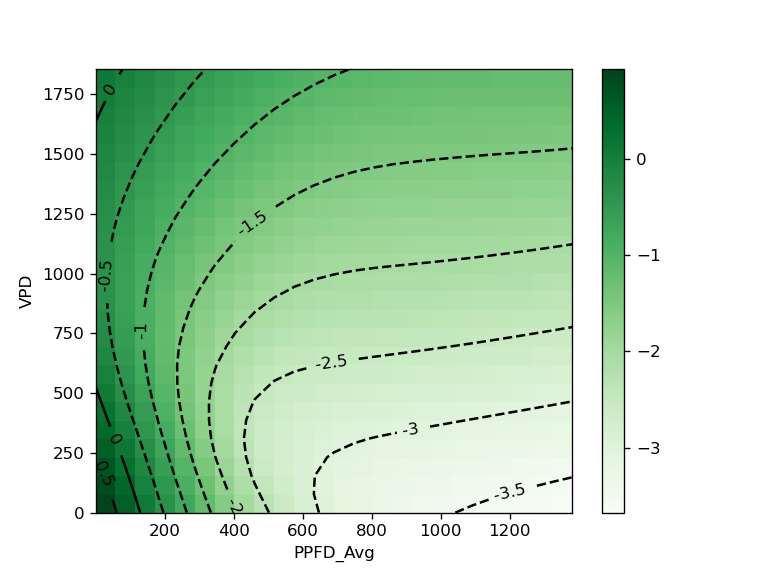

0.278


In [678]:
from matplotlib import colors as c

plt.figure()
Alt=Temp.copy()
Num=0
cm=plt.pcolormesh(Av2[:,:],Bv2[:,:],Temp[Name].values.reshape(N,N)[:,:],cmap='Greens')
Cont = [-4.5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-.5,0,.5,1,1.5]
# Cont = [0,10,20,30,40,50,60,70,80]
CS = plt.contour(Av2[:,:],Bv2[:,:],Temp[Name].values.reshape(N,N)[:,:],Cont,colors='k')

Test = (T30[[Avar,Bvar]]/10).round()*10

# for V in Test[[Avar,Bvar]][Avar].unique():
#     for V2 in Test[[Avar,Bvar]][Bvar].unique():
#         if np.isfinite(V)==True and np.isfinite(V2)==True:
#             if Test.loc[((Test[Avar]==V)&(Test[Bvar]==V2)),[ Avar]].count()[0]==0:
#                 ydddd=1
#             else:
#                 Alt.loc[(((Alt[Avar]/10).round()*10==V)&((Alt[Bvar]/10).round()*10==V2)),Name]=np.nan
# cMap = c.ListedColormap(['grey'])
# plt.pcolormesh(Av2,Bv2,Alt[Name].values.reshape(N,N),cmap=cMap,alpha=.75)

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s

# Recast levels to new class
CS.levels = [nf(val) for val in CS.levels]

# Label levels with specially formatted floats
if plt.rcParams["text.usetex"]:
    fmt = r'%r '
else:
    fmt = '%r '

ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=10)

plt.ylabel(Bvar)
plt.xlabel(Avar)
plt.colorbar(cm)

print(Av2.min())

<IPython.core.display.Javascript object>


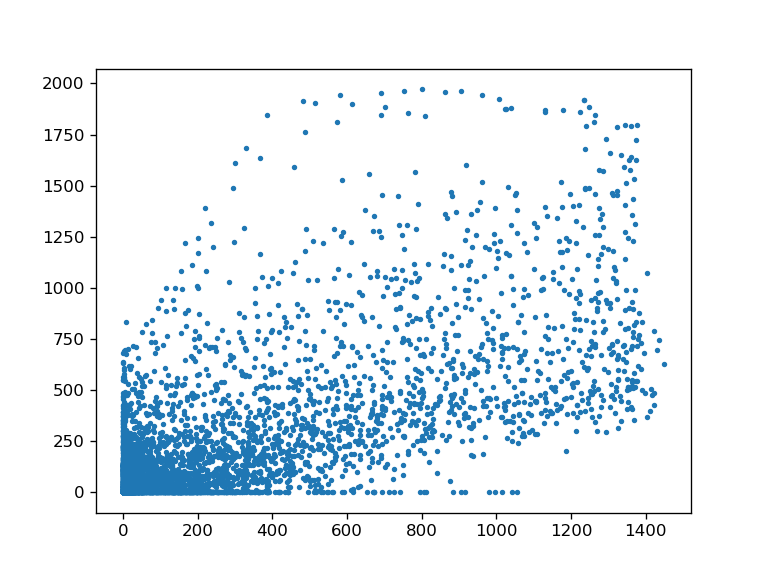

In [680]:
# plt.figure()
# plt.scatter(T30['Temp_5_1']-T30['Temp_15_1'],T30['ch4_flux'])#,c=T30['ch4_flux'])

plt.figure()
plt.scatter(T30[Avar],T30[Bvar],s=5)
# x2=plt.twinx()
# x2.plot(T30['Temp_15_2'],c='r')

In [ ]:

mult = {'fco2':(1e-6 * 12.0107 *1800),
        'ER':1,#(1e-6 * 12.0107 *1800),
        'fch4':(1e-9 * 12.0107 *1800)}
# z

# mult = {'fco2':(1e-6 * 44.0095 *1800),
#         'ER':1,#(1e-6 * 12.0107 *1800),
#         'fch4':(1e-9 * 16.04246 *1800)}

# mult = {'fco2':1,#(1e-6 * 12.0107 *1800),
#         'ER':1,#(1e-6 * 12.0107 *1800),
#             'fch4':1}#(1e-6 * 12.0107 *1800)}
# T30['fch4']*=mult['fch4']
# T30['fco2']*=mult['fco2']
# T30['ER']*=mult['fco2']
for target,name in zip([fch4,fco2],['NME','NEE']):
    target.cols = []
    print(name)
#     print(T30.shape, target.Y_fill[0,:].shape)
    for i in range(target.Y_fill.shape[0]):
        T30['Fill']  = target.Y_fill[i,:]
        B = target.RST.Master[target.target].fillna(T30['Fill'])
        T30[name+'_'+str(i)] = target.RST.Master[target.target].fillna(T30['Fill'])#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)*mult[target.target]
    sp = PooledVar_interval(T30,target.cols,'Mean',n=30)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')

Cols=[]
for i in range(target.Y_fill.shape[0]):
    T30['CBal_'+str(i)]=T30['NME_'+str(i)]*mult['fch4']+T30['NEE_'+str(i)]*mult['fco2']
    Cols.append('CBal_'+str(i))
    
T30['CBal'] = T30[Cols].mean(axis=1)
# sp = PooledVar_interval(T30,Cols,'Mean',n=30)
# target.PooledVar = sp
# target.Mean = T30[name].mean()

for target,name in zip([fch4,fco2],['NME_est','NEE_est','NEE_0','NEE_50','NEE_100']):
    target.cols = []
    for i in range(target.Y_fill.shape[0]):
        T30[name+'_'+str(i)]  = target.Y_fill[i,:]#*mult[target.target]
        target.cols.append(name+'_'+str(i))
    T30[name] = T30[target.cols].mean(axis=1)
    
    sp = PooledVar_interval(T30,[name+'_Var_reg',name+'_Var_er'],'Mean',n=2)
    target.PooledVar = sp
    target.Mean = T30[name].mean()
print('Done')


In [ ]:
def MI(Data,Vars,JustBetween=False):
#     print()
    Mean = Data[Vars].mean().mean()
    WithinVariance = (Data[Vars].std()**2).mean()
    BetweenVariance = 1/(Data[Vars].shape[1]-1)*((Mean-Data[Vars].mean())**2).mean()
    TotalVariance = WithinVariance + (1+1/Data[Vars].shape[1])*BetweenVariance
    if JustBetween == False:
        return(TotalVariance)
    else:
        return(BetweenVariance)




# 1e-6 * 44.0095 *3600,1e-3 * 16.04246 *3600

Temp = T30.copy()
Estimates = []
CIs = []
SE = []
IntType = []
Scale = []
Samples = []
Fluxes = []
Type = []
Targets = {'NEE':fco2,
           'NME':fch4,
           'NEE_est':fco2,
           'NME_est':fch4}
for Var in ['NEE',
            'NME']:#,
    target = Targets[Var]
    if Var == 'NEE' or Var == 'NME' or Var == 'ER':
        CIPI = 'CI'
        Fluxes.append(Var.split('_')[0])
        Type.append('EC Obs.')
        std = MI(Temp,target.cols)**.5*48*mult[target.target]
#         print((std/Temp.shape[0]**.5)*48*mult[target.target]*stats.t.ppf(1-.025,Temp[Var].count()))
        Int=(std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())

    else:
        Fluxes.append(Var.split('_')[0])
        CIPI = 'CI'
        Type.append('EC Obs.')
        std = (Temp[Var+'_Var_reg']).mean()**.5*mult[target.target]*48
        Int=((std)/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp[Var].count())
    SE.append(std)

    U = Temp[Var].sum()/(Temp.shape[0]/48)#*mult[target.target]
    Estimates.append(U)
    CIs.append(Int)

    Scale.append('Footprint')
    
    Samples.append(Temp[Var].count())
    IntType.append(CIPI)
    
std = MI(Temp,Cols)**.5
Int = (std/Temp.shape[0]**.5)*stats.t.ppf(1-.025,Temp['CBal'].count())
print(Temp['CBal'].mean()*48,Int*48)
    
Data = {'Flux':Fluxes,'Scale':Scale,'Estimates':Estimates,
        '95% CI/PI':CIs,'SE':SE,'Interval Type':IntType,'N':Samples,'Type':Type}
# print(Data)
# print(T30[['fch4','NME_est']].mean()*mult['fch4']*48)
# print(T30[['fco2','NEE_est']].mean()*mult['fco2']*48)

# T30['C']

# print(T30[['NME']].mean().values[0]*mult['fch4']*48*1e-3*+T30[['NEE']].mean().values[0]*mult['fco2']*48)
print(Estimates[0]+Estimates[1])
# T30['CBal'] = T30['NEE']+T30['NME']
# print(T30['CBal'].mean()*48,T30['CBal'].std()/(T30['CBal'].count()**.5)*stats.t.ppf(1-0.025,T30['CBal'].shape))

# print(T30[['NME_est']].mean().values[0]*mult['fch4']*48*28*1e-3+T30[['NEE_est']].mean().values[0]*mult['fco2']*48)
# print((T30['NEE_est']-T30['NME_est']*1e-3).mean()8


All = pd.DataFrame(data = Data)
All[['Flux','Type','Scale','Estimates','SE','95% CI/PI']]
# print(ER_fixed.Best)


In [ ]:
plt.figure()
Temp=T30.resample('24H').mean()
# plt.plot(Temp['fco2']*mult['fco2'],color='k')
plt.plot(Temp['NEE'],color='g',marker='*')
plt.plot(Temp['CBal'],color='r',marker='*')
plt.grid()
print(T30['fch4'].mean(),T30['fch4'].std())
print(T30['fco2'].mean(),T30['fco2'].std())

T30['Ratio']=T30['u*']/T30['wind_speed']
T30['Dev'] = ((T30['fch4']-T30['fch4'].mean())/T30['fch4'].std())
print(T30.loc[T30['Dev'].isin(T30['Dev'].nlargest(25))== True,['Dev','u*','wind_speed','Ratio']].mean())
print(T30.loc[T30['Dev'].isin(T30['Dev'].nlargest(25))== True,['Dev','u*','wind_speed','Ratio']].max())
print(T30.loc[T30['Dev'].isin(T30['Dev'].nlargest(25))== True,['Dev','u*','wind_speed','Ratio']].min())
print(T30.loc[np.isnan(T30['fch4'])==False,['u*','wind_speed','Ratio']].mean())
print(T30.loc[np.isnan(T30['fch4'])==False,['u*','wind_speed','Ratio']].max())
print(T30.loc[np.isnan(T30['fch4'])==False,['u*','wind_speed','Ratio']].min())

In [ ]:
T30['Hour']=T30.index.hour-3
T30.loc[T30['Hour']<0,'Hour']+=24
# print(T30['Hour'])
print(T30.index.week.min(),T30.index.week.max())
print(T30.loc[T30.index.week == 30].iloc[1])
Temp = T30.loc[T30.index.week<60]
Hourly = Temp.groupby(Temp.Hour).mean()
HourlySE = Temp.groupby(Temp.Hour).std()/(Temp.groupby(Temp.Hour).count()**.5)
# print(Hourly)
fig,ax=plt.subplots(2,1)
ax[0].bar(Hourly.index,Hourly['NEE']*2,yerr=HourlySE['NEE']*2,color='green')
ax[0].grid()
ax[0].set_title('a.',loc='left')
ax[1].bar(Hourly.index,Hourly['NME_est']*2,yerr=HourlySE['NME_est']*2,color='r')
ax[1].grid()
ax[1].set_title('b.',loc='left')
print(Hourly.loc[((Hourly.index>9)&(Hourly.index<15)),'NME'].mean()*2)

print(T30.groupby(T30.index.week).mean()[['NEE','NME']].max()*48)
plt.savefig('fig3.png')

Daily = T30.resample('D').mean()
Daily[['NME','NEE','CBal','Rain_mm_Tot']] = T30[['NME','NEE','CBal','Rain_mm_Tot']].resample('D').sum()

Weekly = T30.resample('W').mean()
# Weekly[['NME','NEE','CBal','Rain_mm_Tot']] = T30[['NME','NEE','CBal','Rain_mm_Tot']].resample('W').sum()

Daily = Daily[1:-2]

print(T30['NEE'].mean())
print(Daily['NEE'].mean())

print(T30['NME'].mean())
print(Daily['NME'].mean())
# plt.figure()
# print(T30['NEE'])
# print(T30.resample('H').sum()['NEE'])
# print(T30.resample('H').mean()['NEE'])

In [ ]:
fig = plt.figure(figsize=(6.5,7))

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


gs = fig.add_gridspec(10,1)
ax1 = fig.add_subplot(gs[8:])
ax2 = fig.add_subplot(gs[6:8],sharex=ax1)
ax3 = fig.add_subplot(gs[5:6],sharex=ax1)
ax4 = fig.add_subplot(gs[3:5],sharex=ax1)
ax5 = fig.add_subplot(gs[2:3],sharex=ax1)
ax6 = fig.add_subplot(gs[0:2],sharex=ax1)

plt.setp(ax2.get_xticklabels(), visible=False)
plt.setp(ax3.get_xticklabels(), visible=False)
plt.setp(ax4.get_xticklabels(), visible=False)
plt.setp(ax5.get_xticklabels(), visible=False)
plt.setp(ax6.get_xticklabels(), visible=False)



ax6.plot(Daily['AirTC_Avg'],color='r',label='Rn')
ax6.plot(Daily['Temp_5_1'],color='k',label='Soil Temp 5 cm Cent')
ax6.plot(Daily['Temp_5_2'],color='k',label='Soil Temp 5 cm Rim',linestyle=':')

ax5.bar(Daily.index,Daily['PPFD_Avg'],color='orange',edgecolor='k')

ax4.bar(Daily.index,Daily['Rain_mm_Tot'],edgecolor='k')
ax4_2 = ax4.twinx()
ax4_2.plot(Daily['Table_1'],color='k')
ax4_2.plot(Daily['Table_2'],color='k',linestyle=':')

ax3.plot(Daily['wind_speed'],color='k')
ax3_2=ax3.twinx()
ax3_2.plot(Daily['air_pressure']/100,linestyle=':')

ax2.bar(Daily.index,Daily['NME'],color='r',edgecolor='k')

ax1.bar(Daily.index,Daily['NEE'],color='g',edgecolor='k')
ax1_2=ax1.twinx()
ax1_2.plot(Daily['CBal'].cumsum(),color='k')

ax1.set_xlim(datetime.datetime(2017,6,21),datetime.datetime(2017,9,14))


print(Daily['NEE'].mean())
print(Daily['NME'].mean())

In [ ]:
Lims = [
[datetime.datetime(2017, 7, 23,6), datetime.datetime(2017, 7, 26,18)],
# [datetime.datetime(2017, 8, 11), datetime.datetime(2017, 8, 21)],
[datetime.datetime(2017, 7, 29), datetime.datetime(2017, 8, 1)]
       ]
for i,Lim in enumerate(Lims):
    Temp = T30.loc[(T30.index>Lim[0]) & (T30.index<Lim[1])]
    fig,ax=plt.subplots(3,1,figsize=(6.5,7))

    ax[0].plot(Temp['NME_est'],color='k',label='NME_nn')
    ax[0].plot(Temp['ch4_flux']*1e3,color='r',marker='*',label='fch4')
    ax[0].plot(T30['NR_Wm2_Avg']*np.nan,color='b',label='Rn')
    ax2=ax[0].twinx()
    ax2.plot(T30['NR_Wm2_Avg'],color='b')
    ax[0].set_xlim(Lim[0],Lim[1])
    ax[0].legend(loc=2)
    ax[0].set_ylabel('nmol m-2 s-1')
    ax[0].set_title('Methane Fluxes',loc='left')

#     ax[1].plot(Temp['wind_speed'],color='grey',label='u*')
    ax[1].quiver(Temp.index, Temp['wind_speed'], Temp['E'], Temp['N'],
                 scale=50,
                 headwidth=1,
                 headlength=2,
                 pivot='mid',
                 label='wind')#, [C], **kw)
#     ax[1].plot(T30['air_pressure'])

    # ax[1].plot(Lim,[.1,.1])
    ax2=ax[1].twinx()
    ax2.plot(T30['air_pressure'])
#     ax2.plot(Temp['wind_speed'],color='r',label='U')
#     ax[1].plot(Temp['wind_speed']*np.nan,color='r',label='U')
    ax[1].legend(loc=2)
    ax[1].set_xlim(Lim[0],Lim[1])
    ax[1].set_ylabel('m s-1')
#     ax2.set_ylabel('m s-1')
    ax[1].set_title('Wind',loc='left')

#     ax[2].plot(Temp['NR_Wm2_Avg'],color='k',label='Rn')
# #     ax2=ax[2].twinx()
# #     ax2.plot(Temp['Temp_2_5_1'],color='r',label='Ts 2.5 cm')
# #     ax2.plot(Temp['Temp_15_1'],color='purple',label='Ts 15 cm')
# #     ax[2].plot(Temp['Temp_2_5_1']*np.nan,color='r',label='Ts 2.5 cm')
# #     ax[2].plot(Temp['Temp_15_1']*np.nan,color='purple',label='Ts 15 cm')
#     ax[2].legend(loc=2)
#     ax[2].set_xlim(Lim[0],Lim[1])
#     ax[2].set_ylabel('W m2')
#     ax2.set_ylabel('Deg.')
#     ax[2].set_title('Radiation & Soil Temp',loc='left')


    ax[2].plot(Temp['Table_1'],label='Wtd')
    ax2=ax[2].twinx()
    ax2.bar(Temp.index,Temp['Rain_mm_Tot'],color='blue',label='Ts 2.5 cm',width=.01,edgecolor='k')
    ax[2].bar(Temp.index,Temp['Rain_mm_Tot']*np.nan,color='blue',label='Ts 2.5 cm',width=.01,edgecolor='k')
    ax[2].legend(loc=2)
    ax[2].set_xlim(Lim[0],Lim[1])
    ax[2].set_ylabel('depth m')
    ax2.set_ylabel('rain mm')
    ax[2].set_title('Water table & rainfal',loc='left')

    plt.tight_layout()
    plt.suptitle('Case '+str(i+1))
    plt.savefig('Case'+str(i+1)+'.png')
# print(T30.loc[np.isnan(T30['ch4_flux'])==False,'fch4'].count()/T30['NME'].count())
# print(T30.loc[np.isnan(T30['co2_flux'])==False,'fco2'].count()/T30['NME'].count())

In [ ]:
plt.figure()
plt.plot(Daily['Canopy_Height_1'])
plt.plot(Daily['Canopy_Height_2'])


print(T30['Canopy_Height_1'].min())
print(T30['Canopy_Height_2'].min())


print(T30['Canopy_Height_1'].max())
print(T30['Canopy_Height_2'].max())



plt.figure()
plt.plot(Daily['Active_Layer_1'])
plt.plot(Daily['Active_Layer_2'])


# plt.figure()
print(T30['Active_Layer_1'].min())
print(T30['Active_Layer_2'].min())

# plt.figure()
print(T30['Active_Layer_1'].max())
print(T30['Active_Layer_2'].max())


print((T30['Active_Layer_1']-T30['Active_Layer_2']).mean())

print((T30['Temp_2_5_1']-T30['Temp_2_5_2']).mean())
print((T30['Temp_5_1']-T30['Temp_5_2']).mean())
print((T30['Temp_15_1']-T30['Temp_15_2']).mean())
print(T30['AirTC_Avg'].min())
print(T30['AirTC_Avg'].max())

In [ ]:




# ax3 = fig.add_subplot(gs[3:, :3])
# ax4 = fig.add_subplot(gs[3:, 3:])

# fig,ax = plt.subplots(4,1,figsize=(6.5,7),sharex=True)


# ax[0].plot(Daily['NR_Wm2_Avg'],color='k',label='Rn')
# ax[0].plot(Daily['Temp_5_1']*np.nan,color='r',label='Soil Temp 5 cm Cent',linestyle=':')
# ax[0].plot(Daily['Temp_5_2']*np.nan,color='b',label='Soil Temp 5 cm Rim',linestyle=':')
# ax2 = ax[0].twinx()
# ax2.plot(Daily['Temp_5_1'],color='r',label='Soil Temp 5 cm Cent',linestyle=':')
# ax2.plot(Daily['Temp_5_2'],color='b',label='Soil Temp 5 cm Rim',linestyle=':')

# ax[0].set_ylabel('Deg C')
# # ax
# # ax[0].set_ylim(-2,32)
# ax[0].legend(ncol=3,frameon=False)
# ax[0].grid()

# ax1_2=ax[1].twinx()
# ax1_2.bar(Daily.index,Daily['Rain_mm_Tot'],edgecolor='k',label = 'Rainfall')
# ax1_2.plot(Daily['Table_1']*np.nan,color='b',label='Water Table')
# ax1_2.plot(Daily['Active_Layer_1']*np.nan,color='k',label='Thaw Depth')
# ax[1].plot(Daily['Table_1'],color='b',label='Water Table Depth')
# ax[1].plot(Daily['Active_Layer_1']*-1,color='k',label='Thaw Depth')
# ax[1].set_ylabel('Depth m')
# ax1_2.set_ylabel('mm')
# ax[1].grid()
# ax[1].set_ylim(-.52,0.05)
# ax1_2.set_ylim(0,20)
# ax1_2.legend(ncol=3,loc=2,frameon=False)

# ax[2].bar(Daily.index,Daily['NME'],color='r',alpha=.75,edgecolor='k',label = 'Daily NME')
# ax[2].set_ylabel('g C-CH4 m-2 d-1')
# ax[2].grid()
# ax[2].legend(frameon=False)
# # ax2_2=ax[2].twinx()
# # ax2_2.plot(Daily['wind_speed'])

# ax[3].bar(Daily.index,Daily['NEE'],color='g',alpha=.75,edgecolor='k',label = 'Daily NEE')
# # ax[3].bar(Daily.index,Daily['NME'],color='r',alpha=.75,edgecolor='k',label = 'Daily NEE')
# ax3_2 = ax[3].twinx()
# ax3_2.plot((Daily['CBal']).cumsum(),color='k',label = 'Net C Balance')
# # ax3_2.plot(Daily['PPFD_Avg']*-1)
# ax3_2.bar(Daily.index,Daily['NEE']*np.nan,color='g',alpha=.75,edgecolor='k',label = 'Daily NEE')
# ax3_2.set_ylabel('g C m-2')
# ax[3].set_ylabel('g C-CO2 m-2 d-1')
# ax[3].set_ylim(-1.5,0.5)
# ax[3].legend()
# ax[3].grid()
# ax3_2.set_yticks(ax[3].get_yticks()*20)



# # gap=[.2,.2,.2,.85]
# # ax[2].plot(T30.index,T30['fco2'],label='F$_{CO2}$',color='g',marker='+')
# # ax[2].plot(T30.index,T30['NEE_est'],label='NEE$_{NN}$',color=gap)
# # # [0,1,0,.75]
# # ax[2].grid()
# # ax[2].set_title('c',loc='left')
# # ax[2].set_ylabel(r'${\mu}$mol CO$_2$ m$^{-2}$ s$^{-1}$')#${\mu}$mol
# # ax[2].legend(fontsize=9,facecolor='None',edgecolor='None',ncol=2,loc=0)

# # ax[2].set_xticklabels([])


# # ax[3].plot(T30.index,T30['fch4'],label='F$_{CH4}$',color='r',marker='+')
# # ax[3].plot(T30.index,T30['NME_est'],label='NME$_{NN}$',color=gap)
# # ax[3].grid()
# # ax[3].set_title('d',loc='left',pad = -.3)
# # ax[3].set_ylabel(r'nmol CH$_4$ m$^{-2}$ s$^{-1}$')#nmol

# # # ax[2].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
# # # ax[3].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
# # # ax[3].scatter(Dates['Date'],Dates['Value']*0,marker = '*',label = 'Chamber Observations')
# # ax[3].legend(facecolor='None',edgecolor='None',ncol=2,loc=0)


# # ax3_2.set_ylim(-55,35)
# ax[0].set_title('a.',loc='left')
# ax[1].set_title('b.',loc='left')
# ax[2].set_title('c.',loc='left')
# ax[3].set_title('d.',loc='left')
# ax[3].set_xlim(datetime.datetime(2017,6,21),datetime.datetime(2017,9,14))
# # ax3_2.legend(ncol=2,loc=2,frameon=False,bbox_to_anchor=(0, 1.05))


# fig.autofmt_xdate()
# plt.tight_layout()
# plt.savefig('C:\\Users\\wesle\\Dropbox\\PhD_Work/Fig2.png')

# # print(T30[['AirTC_Avg','Temp_2_5_1','Temp_15_1','Table_1','Active_Layer_1']].max())
# # print(T30[['AirTC_Avg','Temp_2_5_1','Temp_15_1','Table_1','Active_Layer_1']].mean())
# # print(T30[['AirTC_Avg','Temp_2_5_1','Temp_15_1','Table_1','Active_Layer_1']].min())
# # print(Daily['Rain_mm_Tot'].sum())
# # print(Daily.loc[Daily['Rain_mm_Tot']>0,'Rain_mm_Tot'].count())

# # print(T30[['NEE','NME']].mean()*24)
# # print(T30['NME'].mean()/34*24)
# # T30['Cbal'] = T30['NEE']+T30['NME']
# # print(T30['Cbal'].mean()*24)
# # print(T30['Cbal'].std()/(T30['Cbal'].count()**.5)*stats.t.ppf(1-.025,T30['Cbal'].count()))

# # Rolling = Daily.rolling(7).mean()
# # Std = T30.resample('D').std()
# print(Daily['NME'].mean(),Daily['NME'].std())
# print((Daily['NME'].nlargest(5)-Daily['NME'].mean())/Daily['NME'].std())
# Daily['Sum']=Daily['CBal'].cumsum()
# print(Daily.loc[Daily['Sum']==Daily['Sum'].min(),'Sum'])
# print(Daily['Sum'][-1])


In [ ]:
fig,ax = plt.subplots(4,1,figsize=(6.5,7),sharex=True)
Daily = T30.resample('D').mean()
Daily[['NME','NEE','CBal','Rain_mm_Tot']] = T30[['NME','NEE','CBal','Rain_mm_Tot']].resample('D').sum()

Weekly = T30.resample('W').mean()
Weekly[['NME','NEE','CBal','Rain_mm_Tot']] = T30[['NME','NEE','CBal','Rain_mm_Tot']].resample('W').sum()

Daily = Daily[1:-2]

ax[0].plot(Daily['NR_Wm2_Avg'],color='k',label='Rn')
ax[0].plot(Daily['Temp_5_1']*np.nan,color='r',label='Soil Temp 5 cm Cent',linestyle=':')
ax[0].plot(Daily['Temp_5_2']*np.nan,color='b',label='Soil Temp 5 cm Rim',linestyle=':')
ax2 = ax[0].twinx()
ax2.plot(Daily['Temp_5_1'],color='r',label='Soil Temp 5 cm Cent',linestyle=':')
ax2.plot(Daily['Temp_5_2'],color='b',label='Soil Temp 5 cm Rim',linestyle=':')

ax[0].set_ylabel('Deg C')
# ax
# ax[0].set_ylim(-2,32)
ax[0].legend(ncol=3,frameon=False)
ax[0].grid()

ax1_2=ax[1].twinx()
ax1_2.bar(Daily.index,Daily['Rain_mm_Tot'],edgecolor='k',label = 'Rainfall')
ax1_2.plot(Daily['Table_1']*np.nan,color='b',label='Water Table')
ax1_2.plot(Daily['Active_Layer_1']*np.nan,color='k',label='Thaw Depth')
ax[1].plot(Daily['Table_1'],color='b',label='Water Table Depth')
ax[1].plot(Daily['Active_Layer_1']*-1,color='k',label='Thaw Depth')
ax[1].set_ylabel('Depth m')
ax1_2.set_ylabel('mm')
ax[1].grid()
ax[1].set_ylim(-.52,0.05)
ax1_2.set_ylim(0,20)
ax1_2.legend(ncol=3,loc=2,frameon=False)

ax[2].bar(Daily.index,Daily['NME'],color='r',alpha=.75,edgecolor='k',label = 'Daily NME')
ax[2].set_ylabel('g C-CH4 m-2 d-1')
ax[2].grid()
ax[2].legend(frameon=False)
# ax2_2=ax[2].twinx()
# ax2_2.plot(Daily['wind_speed'])

ax[3].bar(Daily.index,Daily['NEE'],color='g',alpha=.75,edgecolor='k',label = 'Daily NEE')
# ax[3].bar(Daily.index,Daily['NME'],color='r',alpha=.75,edgecolor='k',label = 'Daily NEE')
ax3_2 = ax[3].twinx()
ax3_2.plot((Daily['CBal']).cumsum(),color='k',label = 'Net C Balance')
# ax3_2.plot(Daily['PPFD_Avg']*-1)
ax3_2.bar(Daily.index,Daily['NEE']*np.nan,color='g',alpha=.75,edgecolor='k',label = 'Daily NEE')
ax3_2.set_ylabel('g C m-2')
ax[3].set_ylabel('g C-CO2 m-2 d-1')
ax[3].set_ylim(-1.5,0.5)
ax[3].legend()
ax[3].grid()
ax3_2.set_yticks(ax[3].get_yticks()*20)



# gap=[.2,.2,.2,.85]
# ax[2].plot(T30.index,T30['fco2'],label='F$_{CO2}$',color='g',marker='+')
# ax[2].plot(T30.index,T30['NEE_est'],label='NEE$_{NN}$',color=gap)
# # [0,1,0,.75]
# ax[2].grid()
# ax[2].set_title('c',loc='left')
# ax[2].set_ylabel(r'${\mu}$mol CO$_2$ m$^{-2}$ s$^{-1}$')#${\mu}$mol
# ax[2].legend(fontsize=9,facecolor='None',edgecolor='None',ncol=2,loc=0)

# ax[2].set_xticklabels([])


# ax[3].plot(T30.index,T30['fch4'],label='F$_{CH4}$',color='r',marker='+')
# ax[3].plot(T30.index,T30['NME_est'],label='NME$_{NN}$',color=gap)
# ax[3].grid()
# ax[3].set_title('d',loc='left',pad = -.3)
# ax[3].set_ylabel(r'nmol CH$_4$ m$^{-2}$ s$^{-1}$')#nmol

# # ax[2].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
# # ax[3].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
# # ax[3].scatter(Dates['Date'],Dates['Value']*0,marker = '*',label = 'Chamber Observations')
# ax[3].legend(facecolor='None',edgecolor='None',ncol=2,loc=0)


# ax3_2.set_ylim(-55,35)
ax[0].set_title('a.',loc='left')
ax[1].set_title('b.',loc='left')
ax[2].set_title('c.',loc='left')
ax[3].set_title('d.',loc='left')
ax[3].set_xlim(datetime.datetime(2017,6,21),datetime.datetime(2017,9,14))
# ax3_2.legend(ncol=2,loc=2,frameon=False,bbox_to_anchor=(0, 1.05))


fig.autofmt_xdate()
plt.tight_layout()
plt.savefig('C:\\Users\\wesle\\Dropbox\\PhD_Work/Fig2.png')

# print(T30[['AirTC_Avg','Temp_2_5_1','Temp_15_1','Table_1','Active_Layer_1']].max())
# print(T30[['AirTC_Avg','Temp_2_5_1','Temp_15_1','Table_1','Active_Layer_1']].mean())
# print(T30[['AirTC_Avg','Temp_2_5_1','Temp_15_1','Table_1','Active_Layer_1']].min())
# print(Daily['Rain_mm_Tot'].sum())
# print(Daily.loc[Daily['Rain_mm_Tot']>0,'Rain_mm_Tot'].count())

# print(T30[['NEE','NME']].mean()*24)
# print(T30['NME'].mean()/34*24)
# T30['Cbal'] = T30['NEE']+T30['NME']
# print(T30['Cbal'].mean()*24)
# print(T30['Cbal'].std()/(T30['Cbal'].count()**.5)*stats.t.ppf(1-.025,T30['Cbal'].count()))

# Rolling = Daily.rolling(7).mean()
# Std = T30.resample('D').std()
print(Daily['NME'].mean(),Daily['NME'].std())
print((Daily['NME'].nlargest(5)-Daily['NME'].mean())/Daily['NME'].std())
Daily['Sum']=Daily['CBal'].cumsum()
print(Daily.loc[Daily['Sum']==Daily['Sum'].min(),'Sum'])
print(Daily['Sum'][-1])


In [ ]:
plt.figure()
Daily = T30.resample('D').mean()
plt.bar(Daily.index,Daily['NME'])
# plt.plot(T30['VWC_1'])


In [ ]:
Temp = T30[['fco2','NEE_est']].dropna()#*mult['fco2']
slope,intercept,r,p,SE = stats.linregress(Temp['fco2'],Temp['NEE_est'])
print(r**2)
print(metrics.r2_score(Temp['fco2'],Temp['NEE_est']))
print(metrics.mean_squared_error(Temp['fco2'],Temp['NEE_est'])**.5)
plt.figure()
plt.scatter(Temp['fco2'],Temp['NEE_est'],facecolor='None',edgecolor='k',s=5)
plt.plot([Temp['fco2'].min(),Temp['fco2'].max()],[Temp['fco2'].min(),Temp['fco2'].max()])
plt.xlim(Temp['fco2'].min(),Temp['fco2'].max())
plt.ylim(Temp['fco2'].min(),Temp['fco2'].max())



Temp = T30[['fch4','NME_est']].dropna()#*mult['fch4']
# Temp = Temp.loc[Temp['fch4']>T30['fch4'].quantile(.05)]
# Temp = Temp.loc[Temp['fch4']<T30['fch4'].quantile(.95)]


slope,intercept,r,p,SE = stats.linregress(Temp['fch4'],Temp['NME_est'])
print(r**2)
print(metrics.r2_score(Temp['fch4'],Temp['NME_est']))
print(metrics.mean_squared_error(Temp['fch4'],Temp['NME_est'])**.5)
plt.figure()
plt.scatter(Temp['fch4'],Temp['NME_est'],facecolor='None',edgecolor='k',s=5)
plt.plot([Temp['fch4'].min(),Temp['fch4'].max()],[Temp['fch4'].min(),Temp['fch4'].max()])
plt.xlim(Temp['fch4'].min(),Temp['fch4'].max())
plt.ylim(Temp['fch4'].min(),Temp['fch4'].max())
print(T30.loc[T30['fch4']<0,'fch4'].count())

In [ ]:
# for c in (T30.columns):
#     print(c)
# print(T30['North'],T30['East'],T30['wind_speed'])
# print()
# print((T30['North']**2+T30['East']**2)**.5,T30['wind_speed'])


# T30['Radians'] = 270-T30['wind_dir']
# T30.loc[T30['Radians']<0,'Radians']+=360
T30['Radians'] = T30['wind_dir']/180*np.pi
T30['North'] = T30['wind_speed'] * np.cos(T30['Radians'])
T30['East'] = T30['wind_speed'] * np.sin(T30['Radians']) 
T30['N']=T30['North']/(T30['North']**2+T30['East']**2)**.5
T30['E']=T30['East']/(T30['North']**2+T30['East']**2)**.5



T30['N']=T30['North']/T30['wind_speed']#(T30['North']**2+T30['East']**2)**.5
T30['E']=T30['East']/T30['wind_speed']#(T30['North']**2+T30['East']**2)**.5
plt.figure()
plt.scatter(T30['N'],T30['E'],s=.1)


print(T30[['N','North','E','East','wind_dir','Radians']])

In [ ]:
Temp=T30.copy()
fig = plt.figure(figsize=(3.5,3.5))


ax2 = plt.subplot(111, projection='polar')

mult=1
X = 'wind_speed'
if X == 'fco2':
    mult = -1
WindBins=[0,2.5,5,7.5,15]
WindLabels=['0-2.5','2.5-5','5-7.5','7.5+']
Temp['Split'] = pd.cut(Temp['wind_speed'], bins=WindBins, labels=WindLabels)
bins = list(np.linspace(0,360,17))
# print(bins)
labels = list(np.arange(12.25,360,22.5))
Temp['Dir'] = pd.cut(Temp['wind_dir'], bins=bins, labels=labels)
Temp['Dir'] = Temp['Dir'].astype(float)
# print(Temp)
Temp['Temp']=1
F = Temp.groupby('Dir').count()
for i,spd in enumerate(WindLabels):
    A = Temp.loc[Temp['Split']==spd].groupby('Dir').mean()
    B = Temp.loc[Temp['Split']==spd].groupby('Dir').count()
#     if i == 0:
#         print(B)
    app = (F.loc[np.isin(F.index,B.index)==False])
    app['Split']=0
#     print(app)
    B = B.append(app)
#     B = B.sort_values(B.index)
    B.Split = B.Split/Temp.Split.count()
    B['D']=B.index
    B = B.sort_values(by='D')
    if i == 0:
        C = B*0
        
    ax2.bar(B.index*np.pi/180,B.Split,bottom=C.Split.values,
       edgecolor=[.2,.2,.2],width=22.5*np.pi/180,label = spd)
    C.Split += B.Split

ax2.legend(loc=6,fontsize=8)
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_rticks([.05,.1,.15])
ax2.set_rlabel_position(220)

In [ ]:
from scipy.optimize import curve_fit
import statsmodels.api as sm

def func (Ratio,m,b):
    return(m*Ratio+b)

# plt.scatter(np.random.rand(10),np.random.rand(10))
Temp = T30[['NME_est','fch4','wind_speed','u*','H','Table_1','wind_dir']].dropna()
# Temp = Temp.loc[Temp['fch4']>Temp['fch4'].quantile(.25)]
Temp['Ratio'] = Temp['u*']/Temp['wind_speed']

# print(T30['DOY'].max()-T30['DOY'].min())
# print(T30['AirTC_Avg'].max(),T30['AirTC_Avg'].min())
# for X in ['u*','wind_speed','Ratio']:
#     X = Temp[X].values
#     Y = Temp['fch4']
#     X = sm.add_constant(X)
#     model = sm.OLS(Y,X)
#     results = model.fit()
# #     print(results.params)
#     print(results.summary())


fig,ax=plt.subplots(2,2,figsize=(10,10))
X = 'u*'
popt_r, pcov = curve_fit(func,Temp[X],Temp['fch4'])
ax[0,0].scatter(Temp[X],Temp['fch4'],
           edgecolor='k',s=10)
ax[0,0].plot(Temp[X],func(Temp[X],*popt_r),
        label=str(np.round(metrics.r2_score(Temp['fch4'],func(Temp[X],*popt_r)),3)))

X = 'wind_speed'
popt_r, pcov = curve_fit(func,Temp[X],Temp['fch4'])
ax[0,1].scatter(Temp[X],Temp['fch4'],
           edgecolor='k',s=10)
ax[0,1].plot(Temp[X],func(Temp[X],*popt_r),
        label=str(np.round(metrics.r2_score(Temp['fch4'],func(Temp[X],*popt_r)),3)))


X = 'Ratio'
popt_r, pcov = curve_fit(func,Temp[X],Temp['fch4'])
ax[1,0].scatter(Temp[X],Temp['fch4'],
           edgecolor='k',s=10)
ax[1,0].plot(Temp[X],func(Temp[X],*popt_r),
        label=str(np.round(metrics.r2_score(Temp['fch4'],func(Temp[X],*popt_r)),3)))
ax[0,0].legend()
ax[0,1].legend()
ax[1,0].legend()


ax[1,1].scatter(Temp['wind_dir'],Temp[X],
           edgecolor='k',s=10)


# plt.label()

# # plt.plot([T30['fch4'].min(),T30['fch4'].max()],[T30['fch4'].min(),T30['fch4'].max()],color='k')
# plt.legend()
# # plt.title('FCH4')
# # plt.savefig('FCH4_Performance.png')

# plt.figure()
# Temp = T30[['NEE_est','fco2']].dropna()
# plt.scatter(T30['NEE_est'],T30['fco2'],
#             label = 'r^2 '+str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),2)),
#            edgecolor='k',s=10)
# plt.plot([T30['fco2'].min(),T30['fco2'].max()],[T30['fco2'].min(),T30['fco2'].max()],color='k')
# plt.legend()
# plt.title('FCO2')
# plt.show()
# plt.savefig('FCO2_Performance.png')


In [ ]:

def Mechanistic(uT,a,b,c):
    return(a*np.exp(b*uT[:,1]+c*uT[:,0]))

# def Mechanistic(u,T,a,b,c):
#     return(a*np.exp(b*T+c*u))
           
Test = Temp[['fch4','u*','Temp_5_1']].dropna()
popt_r, pcov = curve_fit(Mechanistic, Test[['u*','Temp_5_1']].values,Test['fch4'])
# print(popt_r)

plt.figure()
plt.scatter(Test['fch4'],Mechanistic(Test[['u*','Temp_5_1']].values,*popt_r),
           label=metrics.r2_score(Test['fch4'],Mechanistic(Test[['u*','Temp_5_1']].values,*popt_r)))
plt.legend()
plt.figure()
plt.plot(Test['fch4'])
plt.plot(Test.index,Mechanistic(Test[['u*','Temp_5_1']].values,*popt_r))
# def R_func(T,r1,r2,r3):
#     return(1/(r1*r2**T+r3))

# # Dark = T30.loc[T30['PPFD_Avg']<10,['Temp_5_1','fco2']].dropna()
# # Dark = Dark.loc[Dark['VWC']>Dark['VWC'].quantile(.5)]
# # print(Dark.shape)
# Test = Temp[['fco2','Temp_5_1']].dropna()
# popt_r, pcov = curve_fit(R_func, Test['Temp_5_1'], Test['fco2'])#,p0=( 45.9262144,0.5875255,2.7508822))
# print(popt_r)

In [ ]:

from keras.models import model_from_json
params=fco2_Alt.params
json_file = open(params['Spath']+'Y_.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# return(loaded_model)
loaded_model.summary()
print(loaded_model.get_config())

# def Load_Weights(loaded_model,params):
loaded_model.load_weights(params['Spath']+'Y_0.h5')
# Weights = loaded_model.get_weights()


for layerNum, layer in enumerate(loaded_model.layers):
    weights = layer.get_weights()[0]
    biases = layer.get_weights()[1]
#     print(weights.T*[1,0],biases)
    
    for toNeuronNum, bias in enumerate(biases):
        print(f'{layerNum}B -> L{layerNum+1}N{toNeuronNum}: {bias}')
    
    for fromNeuronNum, wgt in enumerate(weights):
        for toNeuronNum, wgt2 in enumerate(wgt):
            print(f'L{layerNum}N{fromNeuronNum} -> L{layerNum+1}N{toNeuronNum} = {wgt2}')

In [ ]:

for j in range(len(Modd.Weights)):
    W = Modd.Weights[j]
    # print(len(W))
#     for J in W:
#         print(J.shape)
    T = ((np.abs(W[0])*np.abs(W[2][:,0])))
#     T = (((W[0])*(W[2][:,0])))
    for i in range(T.shape[-1]):
        T[:,i]=T[:,i]/T[:,i].sum()
    Weights = (np.nansum(T,axis=1))
#     idx = [i for i in range(0,Weights.shape[0])]
    if j == 0:
        Factors = pd.DataFrame(index=Modd.params['Inputs'],data={str(j):Weights})
    else:
        Factors[str(j)]=Weights
Factors['Rank']=Factors.mean(axis=1)/Factors.mean(axis=1).sum()
plt.figure()
plt.bar(Factors.index,Factors['Rank'])
plt.xticks(rotation=90)
plt.show()

In [ ]:
Vars = fco2_Alt.Model_Selection.split('+')
target = fco2_Alt
# print(target.RST.params['Inputs'])
n=3
List = []
x,y='PPFD_Avg','Table_1'
for var in Vars:
    if var == x:# or var == y:
        List.append(np.linspace(T30[var].min(),T30[var].max()*500,20))
    else:
        List.append([T30[var].quantile(.5)])#np.linspace(T30[var].min(),T30[var].max(),n))
# print(List)
Temp = pd.DataFrame(data=np.array(list(itertools.product(*List))),columns=Vars)
target.RST.Data=Temp
target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
target.Map()

In [ ]:
fch4 = ResultMap('fch4',Test='SE',Rule=1)
fco2 = ResultMap('fco2',Test='SE',Rule=1)
print(fch4.Best)
print(fco2.Best)
plt.figure()
plt.plot(fco2.Records.groupby('Size').min()['MSE'])
plt.plot(fch4.Records.groupby('Size').min()['MSE']/1e3)
# plt.plot(fco2.Records.groupby('Size').min()['MSE'])
# plt.plot(fch4.Records.groupby('Size').min()['MSE']/1e3)
x2 = plt.twinx()
x2.plot(fco2.Records.groupby('Size').max()['r2'],linestyle = '-.')
x2.plot(fch4.Records.groupby('Size').max()['r2'],linestyle = '-.')

In [ ]:
# fch4.Model_Selection='H+Table_1+VWC_1+u*+air_pressure'
# print(fch4.Best)
T30 = fco2.RST.Master.copy()
T30 = Mapper(T30,fch4,'NME_est',Fill = False)
T30 = Mapper(T30,fco2,'NEE_est',Fill = False)
i,j=0,0

# fig,ax = plt.subplots(len(fch4.params['Inputs']),1,figsize = (8,20))
# plt.locator_params(nbins=10)
# for var in fch4.params['Inputs']:
#     T30[var].plot.hist(ax=ax[i],bins=15,edgecolor='k')
#     ax[i].set_title(var)
#     ax[i].grid()
#     i += 1
# plt.tight_layout()
# print(Vars)

In [ ]:
# print()
W = fco2.Weights[0]
print(len(W))

for J in W:
    print(J.shape)
#     print(np.sum(J,axis=1).shape)
# X = W[0]+W[1]+W[2][0]+W[3]
X = (((np.abs(W[5])*np.abs(W[4])*np.abs(W[3])).sum(axis=1)*np.abs(W[2])).sum(axis=1)*np.abs(W[1])*np.abs(W[0])).sum(axis=1)

# print(W[5])
# print(W[3])
print()
print(X.shape)
print(X/X.sum())
# print(X.sum(axis=1),X.sum(axis=1)/X.sum(axis=1).sum())

In [ ]:
# plt.figure()
# for i, val in enumerate(fco2.Records.groupby('Size').min()['MSE'].values):
#     A = (fco2.Records.loc[fco2.Records['MSE']==val,['Model','MSE','SE']])
#     plt.bar(i,A['MSE'].values[0],yerr=A['SE'].values[0])
fig,ax=plt.subplots()
for i, val in enumerate(fch4.Records.groupby('Size').min()['MSE'].values):
    B = (fch4.Records.loc[fch4.Records['MSE']==val,['Model','MSE','SE']])
    ax.bar(i,B['MSE'].values[0],yerr=B['SE'].values[0])
lbl_ch4 = []
for i,val in enumerate(fch4.Records.groupby('Size').min()['MSE'].values):
    Lista = fch4.Records.loc[fch4.Records['MSE']==val,'Model'].values[0].split('+')
    Listc = Lista.copy()
    if i >0:
        for b in Listb:
#             print(b)
            try:
                Lista.remove(b)
            except:
                pass
        lbl_ch4.append('+'.join(Lista))
#         print()
    Listb = Listc.copy()
print(lbl_ch4)
ax.set_xticks([x for x in range(0,fch4.Records.Size.max())])
ax.set_xticklabels(lbl_ch4,rotation=75)
plt.tight_layout()
# a = ['H', 'VWC_1']
# a.remove('H')

In [ ]:
# print(fch4.Min['MSE'].values[0]+fch4.Min['SE'].values[0])
# print(fch4.Records.loc[fch4.Records['MSE']<=(fch4.Min['MSE'].values[0]+fch4.Min['SE'].values[0]),['Size']])

In [ ]:
# print(fch4.Records.loc[(fch4.Records.Size ==1),['Model','MSE','SE','r2']].sort_values('MSE'))
# print(fco2.Records.loc[(fco2.Records.Size ==1),['Model','MSE','SE','r2']].sort_values('MSE'))
# Values=['PPFD_Avg','NR_Wm2_Avg','Active_Layer_1','VWC_1',
#  'Delta_Temp_2','Temp_15_1','u*','VPD','Temp_15_2','Delta_Temp_1',
#  'Table_1','VWC_2','wind_speed','Temp_5_2','AirTC_Avg','Delta_Table_1',
#  'air_pressure','Delta_VWC_1','Total_Rain_mm_Tot','Delta_VWC_2','Temp_5_1']

# for val in Values:
#     print(fco2.Records.loc[
#         ((fco2.Records.Size ==1)&
#         (fco2.Records.Model==val))])

In [ ]:
# Vars=['H','VWC_1','Table_1','u*','air_pressure']
Vars = fch4.Model_Selection.split('+')
target = fch4
print(target.RST.params['Inputs'])
n=3
List = []
x,y='VWC_1','AirTC_Avg'
for var in Vars:
    if var == x or var == y:
        List.append(np.linspace(T30[var].min(),T30[var].max(),10))
    else:
        List.append([T30[var].quantile(.5)])#np.linspace(T30[var].min(),T30[var].max(),n))
print(List)
Temp = pd.DataFrame(data=np.array(list(itertools.product(*List))),columns=Vars)
target.RST.Data=Temp
target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
target.Map()

In [ ]:
%matplotlib notebook
Temp = target.Data_Map


z=target.target
for var in fch4.params['Inputs']:
    if var != x and var != y:
        Temp = Temp.loc[Temp[var]==Temp[var].iloc[0]]


Selection = Temp[[x,y,z,'CI']]
               
Select = Selection.values.reshape(10,10,-1)
print(Select.shape)

# print(Temp)
X = Select[:,:,0]
Y = Select[:,:,1]
Z = Select [:,:,2]#*mult[target.target]

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)

ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.set_xlabel(x)
ax.set_ylabel(y)
fig.colorbar(surf, shrink=0.5, aspect=5)
# ax.set_xlim(0,1)
# ax.set_zlim(0,100)
plt.show()

In [ ]:
# plt.figure()
# # plt.plot(T30['Table_1'])
# plt.scatter(T30['fch4'],T30['Table_1'])
# a,b=-.1,.02
# c,d=102000,500
# print(T30.loc[
#     ((np.abs(T30['Table_1']-a)<b)&
#     (np.abs(T30['air_pressure']-c)<d)),
#     'fch4'
# ].count())

In [ ]:

plt.figure()
Temp=T30[['NME_est','fch4']].dropna()
# print(T30[['NME_est','fch4']])
LM = T30['fch4'].min(),T30['fch4'].max()
plt.plot(LM,LM,color='black')
plt.scatter(T30['fch4'],T30['NME_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fch4'],Temp['NME_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')

plt.figure()
Temp=T30[['NEE_est','fco2']].dropna()
# print(T30[['NME_est','fch4']])
LM = T30['fco2'].min(),T30['fco2'].max()
plt.plot(LM,LM,color='black')
plt.scatter(T30['fco2'],T30['NEE_est'],c='red',edgecolor='black',alpha=.5,s=10,
           label=str(np.round(metrics.r2_score(Temp['fco2'],Temp['NEE_est']),3)))
plt.grid()
plt.legend()
plt.xlabel('Observation')
plt.ylabel('Estimate')

In [ ]:
Filled = fch4.Data_Map#['fch4']
# fch4.RST.Data['datetime'] = fch4.RST.Data.index
# fch4.RST.Data=fch4.RST.Data.reset_index(drop=True)
Filled['datetime']=np.nan
Filled['datetime']=fch4.RST.Data.index
Filled = Filled.set_index(pd.DatetimeIndex(Filled['datetime']))
# Filled.loc[((Filled.index.dayofyear<174)|(Filled.index.dayofyear>256)),'fch4']=np.nan
plt.figure()
plt.plot(Filled['fch4'].resample('M').mean())
fig.autofmt_xdate()
print(fch4.RST.Data.shape,Filled.shape,Taglu.shape)
# # print(fch4.Data_Map['fch4'].mean())
# print(fch4.RST.Data['datetime'])
# # print(fch4.Data_Map.shape,Taglu.shape)
# plt.figure()
# Temp = Taglu.copy()#reset_index(drop=True)

# plt.plot(Temp.index)
plt.figure()
plt.scatter(Filled['fch4'].resample('H').mean(),Filled['VWC Trnd'].resample('H').mean())
print(Filled.loc[Filled['fch4']<=-100])

In [ ]:
print(fch4.params['Inputs'])
Temp = Taglu#.loc[(Taglu.index.month>5)&(Taglu.index.month<10)]
# Temp = Taglu
plt.figure(figsize=(10,10))
plt.title('SoilMoist(1)')
plt.plot(Temp['SoilMoist(1)'].resample('D').mean(),marker='*')
fig.autofmt_xdate()
plt.figure(figsize=(10,10))
plt.title('SoilMoist(4)')
plt.plot(Temp['SoilMoist(4)'].resample('D').mean(),marker='*')
fig.autofmt_xdate()
plt.figure(figsize=(10,10))
plt.title('Rainfall_Tot')
plt.plot(Temp['Rainfall_Tot'].resample('M').sum(),marker='*')
fig.autofmt_xdate()

In [ ]:


# T30['GPP'] = -1*T30['NEE_est']+T30['ER_interp_est']
# T30['GPP_fixed'] = -1*T30['NEE_fixed_est']+T30['ER_fixed_est']


# T30 = T30.loc[((T30.index>'2016-07-10 23:30:00') & (T30.index<'2016-08-07 00:00:00'))]
HafHourly = T30.resample('D').mean()
# v='NEE'

# HafHourly['Total_Rain_mm_Tot'] = T30['Total_Rain_mm_Tot'].resample('D').sum()
HafHourlys = T30.resample('D').std()
for target,v in zip([fco2,fch4],['NEE','NME']):
#     HafHourly[v+'Pooled_CI'] = 0
#     HafHourly[v+'Pooled_PI'] = 0
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
#         if v
#         pooled_std = 
        HafHourly.loc[HafHourly.index==day,v+'_Var']=MI(Samp,target.cols,JustBetween=True)*48#/(Samp.shape[0]**.5)*stats.t.ppf(1-.025,Samp.shape[0])
#         HafHourly.loc[HafHourly.index==day,v+'_Std']=pooled_std#*((1/Samp.shape[0]+1/T30.shape[0])**.5)*stats.t.ppf(1-.025,Samp.shape[0])

for target,v in zip([fco2,fch4],['NEE_est','NME_est']):
    for day in HafHourly.index:
        Samp = T30.loc[(T30.index>=day)&(T30.index<day+datetime.timedelta(days=1))]
        HafHourly.loc[HafHourly.index==day,v+'_Var']=(Samp[v+'_Var_reg']).mean()**.5*mult[target.target]#*48
    

Daily = T30.resample('D').sum()
# Daily['ER_Sum'] = HafHourly['ER']+0
# Daily['ER_CI'] = (HafHourly['ER_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
# Daily['ER_est_CI'] = (HafHourly['ER_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_CI'] = (HafHourly['NEE_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NEE_est_CI'] = (HafHourly['NEE_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_CI'] = (HafHourly['NME_Var']**.5)/(48**.5)*stats.t.ppf(1-.025,48)*48#
Daily['NME_est_CI'] = (HafHourly['NME_est_Var'])/(48**.5)*stats.t.ppf(1-.025,48)*48#

# print(Daily[['ER_CI','ER_est_CI']])
# print(HafHourly['NEE_est_Var']/(48**.5)*stats.t.ppf(1-.025,48)*48)
# print(Daily[['ER','ER_CI']])
# print(HafHourly)*
Weekly = Daily[['NEE','NME']].resample('W').mean()
print(Weekly['NME']*16.01/12.01)
print(Weekly[['NEE']]*44.01/12.01)

In [ ]:
# print(Daily['Total_Rain_mm_Tot'])

In [ ]:

# Dates = pd.read_csv('ChamberDates.csv')

fig,ax = plt.subplots(4,1,figsize = (6.5,7),sharex=True)
ax[0].plot(T30['AirTC_Avg'],color='red',label = 'T$_a$')
# ax[0].plot(T30['Temp'],color='black',label = 'T$_s$')
ax[0].bar(T30.index,T30['PPFD_Avg']*np.nan,facecolor='orange',edgecolor='black',label = 'PPFD')
ax[0].set_ylim(0,30)
yax2 = ax[0].twinx()
yax2.bar(HafHourly.index+datetime.timedelta(hours=12),HafHourly['PPFD_Avg'],
         facecolor='orange',edgecolor='black',label = 'PPFD')
# yax2.set_ylim(0,600)

ax[0].grid()
ax[0].set_zorder(ax[0].get_zorder()+1)
ax[0].patch.set_visible(False)

yax2.set_ylabel('${\mu}$mol m$^{-2}$ s$^{-1}$')
ax[0].set_ylabel('$^\circ$C')
ax[0].legend(ncol = 3,fontsize=9,loc=0,facecolor='None',edgecolor='None')
ax[0].set_title('a',loc='left')

yax2 = ax[1].twinx()
yax2.bar(Daily.index+datetime.timedelta(hours=12),Daily['Total_Rain_mm_Tot'],
         facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
# ax[1].bar(Daily.index,Daily['Rain_mm_Tot']*np.nan,label = 'Daily Total Rainfall')
# yax2.set_ylim(0,10)

ax[1].plot(T30['VWC_1'],color='blue',label = 'Soil Water Content')
# ax[1].plot(fco2.RST.Master['VWC'],color='orange',label = 'Soil Water Content')
ax[1].bar(Daily.index,Daily['Total_Rain_mm_Tot']*np.nan,facecolor='cyan',edgecolor='black',label = 'Daily Total Rainfall')
# ax[1].set_ylim(.50,.6)
ax[1].grid()
ax[1].set_zorder(ax[1].get_zorder()+1)
ax[1].patch.set_visible(False)
yax2.set_ylabel('mm')
ax[1].set_ylabel('%')
ax[1].set_title('b',loc='left')
ax[1].legend(ncol=2,fontsize=9,facecolor='None',edgecolor='None')

# ax[0].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])
# ax[1].set_xlim([datetime.datetime(2016, 7, 10, 12), datetime.datetime(2016, 8, 7,12)])

# ax[2].bar(Daily.index+datetime.timedelta(hours=12),Daily['ER_est'],
#           error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           edgecolor = 'black',facecolor=[1,1,.5,.5],label='ER')
ax[2].bar(Daily.index+datetime.timedelta(hours=12),Daily['NEE']*mult['fco2'],
          edgecolor = 'black',facecolor=[0,1,0,.75],
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label='NEE')

ax[2].grid()
ax[2].set_title('c',loc='left')
ax[2].set_ylabel('g C-CO$_2$ m$^{-2}$ d$^{-1}$')#${\mu}$mol
ax[2].legend(fontsize=9,facecolor='None',edgecolor='None',ncol=2,loc=0)

ax[2].set_xticklabels([])


ax[3].bar(Daily.index+datetime.timedelta(hours=12),Daily['NME']*mult['fch4'],
          edgecolor = 'black',facecolor=[1,0,0],
          error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
          label ='NME')
# ax[3].bar(Daily.index+datetime.timedelta(hours=12),Daily['NME_fixed_est'],
#           edgecolor = 'black',facecolor=[0,0,1,.5],
#           error_kw=dict(ecolor='black', lw=1, capsize=4, capthick=1),
#           label ='NME')
ax[3].grid()
ax[3].set_title('d',loc='left',pad = -.3)
ax[3].set_ylabel('mg C-CH$_4$ m$^{-2}$ d$^{-1}$')#nmol

ax[2].set_xlim([datetime.datetime(2017, 6, 21, 12), datetime.datetime(2017, 9, 14, 12)])
ax[3].set_xlim([datetime.datetime(2017, 6, 21, 12), datetime.datetime(2017, 9, 14, 12)])
# ax[3].scatter(Dates['Date'],Dates['Value']*0,marker = '*',label = 'Chamber Observations')
ax[3].legend(facecolor='None',edgecolor='None')

fig.autofmt_xdate()
plt.tight_layout(pad=0.25)

# plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig3.png',dpi=300)

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig2.png',dpi=300)

In [ ]:
fch4.Project(Projector = None,Model = None)
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])


y_pred = reg.predict(fch4.RST.Data[fch4.params['Inputs']])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))
y_pred2 =  reg.predict(fch4.RST.Data[fch4.params['Inputs']])
# reg.coef_

# reg.intercept_ 

# reg.predict(np.array([[3, 5]]))
             
# print()
fch4.RST.Data['y_pred2']=y_pred2
plt.figure()
# Var = 'Sedge'
Var = 'SoilMoist(1)'
plt.scatter(fch4.RST.Data[Var],fch4.RST.Data['y_pred2'])

from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_leaf_nodes= int(10),min_samples_leaf=30,random_state=1)
print(fch4.params['Inputs'])
forest.fit(fch4.RST.Data[fch4.params['Inputs']],fch4.RST.Data[fch4.params['target']])

y_pred = forest.predict(fch4.RST.Data[fch4.params['Inputs']])
y_pred3=forest.predict(fch4.RST.Data[fch4.params['Inputs']])
fch4.RST.Data['y_pred3']=y_pred3
plt.scatter(fch4.RST.Data[Var],fch4.RST.Data['y_pred3'])
print(metrics.mean_squared_error(y_pred,fch4.RST.Data[fch4.params['target']]))
print(metrics.r2_score(fch4.RST.Data[fch4.params['target']],y_pred))

In [ ]:
## R2 = .58 for ER - Modeled @ PPFD_Avg<10
def P_func(PPFD,MQY,PM):
    cv =.7
    return((MQY*PPFD + PM - ((MQY*PPFD + PM)**2 - 4*cv*MQY*PPFD*PM)**.5)/(2*cv))
def R_func(T,r1,r2,r3):
    return(1/(r1*r2**T+r3))
def R_func2(T,Q10,R10):
    return(R10*Q10**((T-10)/10))

Dark = T30.loc[T30['PPFD_Avg']<10,['Temp','fco2','ER_est','ER_interp_est','ER_fixed_est',
#                                    'Temp_10_est','Temp_0_est',
#                                    'ER_10_est','ER_0_est',
                                   'ER','AirTC_Avg','VPD','Sedge','Shrub','VWC']].dropna()
# Dark = Dark.loc[Dark['VWC']>Dark['VWC'].quantile(.5)]
popt_r, pcov = curve_fit(R_func, Dark['Temp'], Dark['fco2'],p0=( 45.9262144,0.5875255,2.7508822))
popt_r2, pcov2 = curve_fit(R_func2, Dark['AirTC_Avg'], Dark['fco2'])#,p0=( 4.59262144,0.5875255,0.27508822))
print(popt_r2[0],popt_r2[1])
#p0=( 74.59262144,0.8875255,2.27508822)
# print(metrics.r2_score(Dark['fco2'],R_func2(Dark['Temp'],*popt_r2)))

plt.figure()
plt.scatter(Dark['fco2'],R_func(Dark['Temp'],*popt_r),c='red',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),2)))
plt.scatter(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2),c='pink',
            label='Model '+str(np.round(metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)),2))
           )
Dark['ER3'] = (R_func2(Dark['AirTC_Avg'],*popt_r2))
plt.scatter(Dark['fco2'],Dark['ER_est'],c='blue',
            label='Est '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_est']),2)))
plt.scatter(Dark['fco2'],Dark['ER_interp_est'],c='green',
            label='Interp '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_interp_est']),2)))
# plt.scatter(Dark['fco2'],Dark['ER_0_est'],c='pink',
#             label='0 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_0_est']),2)))
# plt.scatter(Dark['fco2'],Dark['ER_10_est'],c='brown',
#             label='10 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['ER_10_est']),2)))
# Dark[['Temp_0_est','Temp_10_est']]*=mult['fco2']
# plt.scatter(Dark['fco2'],Dark['Temp_0_est'],c='yellow',
#             label='Temp_0 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['Temp_0_est']),2)))
# plt.scatter(Dark['fco2'],Dark['Temp_10_est'],c='cyan',
#             label='Temp_10 '+str(np.round(metrics.r2_score(Dark['fco2'],Dark['Temp_10_est']),2)))
# plt.colorbar()
plt.plot([Dark['fco2'].min(),Dark['fco2'].max()],[Dark['fco2'].min(),Dark['fco2'].max()],
         label='1:1',color='black')
plt.ylabel('pred')
plt.xlabel('tru')
plt.legend()

# plt.xlim(0,1)
# plt.ylim(0,1)
plt.grid()
T30['ER2'] = R_func(T30['Temp'],*popt_r)
T30['ER3'] = R_func2(T30['AirTC_Avg'],*popt_r2)


P = T30[T30['PPFD_Avg']>=10]
P = P[['fco2','ER2','ER3','PPFD_Avg']].dropna()
popt_p, pcov = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER2']),p0=(.01,10))
popt_p3, pcov3 = curve_fit(P_func, P['PPFD_Avg'], -1*(P['fco2']-P['ER3']),p0=(.01,10))
# T30['GPP2'] = Data['GPP'].fillna(P_func(Data['PPFD_Avg'],*popt_p))
T30['GPP2'] = P_func(T30['PPFD_Avg'],*popt_p)
T30['GPP3'] = P_func(T30['PPFD_Avg'],*popt_p3)
T30['NEE2'] = T30['ER2']-T30['GPP2']
T30['NEE3'] = T30['ER3']-T30['GPP3']


Temp = T30.loc[np.isnan(T30['fco2'])==False]
print('Mean ER:')
# print(Temp[['ER','ER_est','ER2','ER3']].mean()*mult['fco2'])
# print(Dark['fco2'].mean())
print()
print('R2 Score:')
print('ER_est: ',metrics.r2_score(Dark['fco2'],Dark['ER_est']),
     'ER2: ',metrics.r2_score(Dark['fco2'],R_func(Dark['Temp'],*popt_r)),
     'ER3: ',metrics.r2_score(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2)))
print()
print('MSE:')
print('ER_est: ',metrics.mean_squared_error(Dark['fco2'],Dark['ER_est'])**.5,
     'ER2: ',metrics.mean_squared_error(Dark['fco2'],R_func(Dark['Temp'],*popt_r))**.5,
     'ER3: ',metrics.mean_squared_error(Dark['fco2'],R_func2(Dark['AirTC_Avg'],*popt_r2))**.5)
print(Dark['fco2'].count())
print(Dark[['fco2','ER_est']].mean(),R_func2(Dark['AirTC_Avg'],*popt_r2).mean())
# for q in [0,.25,.5,.75,1]:
#     print(Dark[['VWC','Shrub','Sedge']].quantile(q))
#     print()
# plt.figure()
# plt.scatter(Dark['ER_est'],Dark['ER_interp_est'])
# print(Dark['ER_est'].mean(),Dark['ER_interp_est'].mean())
# print(ER.Model_Selection)
# plt.figure()
# plt.scatter(Dark['ER_fixed_est'],Dark['ER_est'])
# plt.scatter(Dark['AirTC_Avg'],Dark['ER_0_est'])
# plt.scatter(Dark['AirTC_Avg'],Dark['ER_est'])
# print(ER.Model_Selection,ER_0.Model_Selection)
# print(ER_10.Model_Selection)

In [ ]:
def Plot(ax,Label,Data,regressor,color,target,Interval=None,linestyle='-',mult=1,alpha=None): 
    rgba = color.copy()
    if alpha is None:
        rgba[3]=.05
    else:
        rgba.append(alpha)
    Data = Data.sort_values(regressor)#.reset_index()
    try:
        Data['True']*=1
    except:
        Data['True']=0
        pass
    ax.plot(Data[regressor],Data[target]*mult,
            label= Label,
            linestyle=linestyle,
            linewidth=1.5,
            color = color)
    if Interval != None:
        ax.fill_between(Data[regressor],
                    mult*(Data[target]-Data[Interval]), 
                    mult*(Data[target]+Data[Interval]),
                    facecolor = rgba,
                    edgecolor = color,
                    linestyle=':',
                    linewidth=1,
                   )

In [ ]:

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

def MapJobs(target,Range,N,Mask={},map_range=None):
    target.Project(Projector = None,Model = None)
    columns=[Range]
    l = 1
    for key in Mask.keys():
        columns.append(key)  
        l+=1
    for v in target.params['Inputs']:
        if v not in columns:
            columns.append(v)
    try:
        scaler = StandardScaler()
        scaler.fit(target.RST.Data[columns[l:]])
        Temp = scaler.transform(target.RST.Data[columns[l:]])
        Temp = pd.DataFrame(data = Temp,columns = columns[l:])
        kmeans = KMeans(n_clusters=N, random_state=0).fit(Temp)
        Q = scaler.inverse_transform(kmeans.cluster_centers_)
    except:
        Q = []
        for col in columns[1:]:
            Q.append(Mask[col])
        Q=np.asanyarray(Q).T
        pass
    columns.append('target')
    def Make(Data,columns,map_range,values,C=20,Mask=None,i=0):
        ranges = [np.linspace(map_range[0],map_range[1],C)]
        for key in Mask.keys():
            ranges.append(np.ones(C)*Mask[key])
        for v in values:
            ranges.append(np.ones(C)*v)
        ranges.append(np.ones(C)*0)
        data = {}
        for (col,ran) in zip(columns,ranges):
            data[col]=ran
        data['key']=i
        
        return(pd.DataFrame(data = data))
    tarList=[]
    if map_range is None:
        map_range = [target.RST.Data[columns[0]].min(),target.RST.Data[columns[0]].max()]
    if len(Q) == 0:
        Data = Make(target.RST.Data,columns,
                    map_range=map_range,
                    values=[],Mask={key:item[i] for key, item in Mask.items()})
    for i,quantile in enumerate(Q):
        values = []
        for q in quantile:
            values.append(q)
        if i == 0:
            Data = Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()})
        else:
            Data = Data.append(Make(target.RST.Data,columns,
                    map_range=map_range,values=values,C=30,
                    Mask={key:item[i] for key, item in Mask.items()},i=i))
    target.RST.Data=Data
    target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
    target.Map()
    tarList.append(target.Data_Map)  
    return(tarList,Q,columns[1:-1],Data,target,Range)

In [ ]:
import itertools
target = fco2#_interp
List = []
n = 25
Vars = []
print(target.Best['Model'])
for var in target.Best['Model'].values[0].split('+'):
    Vars.append(var)
#     List.append([T30[var].quantile(q/100) for q in range(0,101,10)])
    List.append(np.linspace(T30[var].min(),T30[var].max(),n))
Temp = pd.DataFrame(data=np.array(list(itertools.product(*List))),columns =Vars)
target.RST.Data=Temp
target.RST.Scale(target.RST.params['target'],target.RST.params['Inputs'],ScalePath=target.RST.params['Spath'],Project=True)
target.Map()

Temp = target.Data_Map

# Mapping Taglu data. don't delete!

In [ ]:
fch4_Taglu = ResultMap('fch4',Test='SE',Rule=1,DataName='TagluData.csv',AltPath='Taglu')
fco2_Taglu = ResultMap('fco2',Test='SE',Rule=1,DataName='TagluData.csv',AltPath='Taglu')

print(fch4_Taglu.Model_Selection)
print(fco2_Taglu.Model_Selection)

In [ ]:
Taglu = pd.read_csv('C:\\Users\\wesle\\NetworkAnalysis/FishIsland//TagluRecord.csv')
Taglu['fco2']=np.nan
Taglu['fch4']=np.nan
Taglu.head()
Taglu = Taglu.set_index(pd.DatetimeIndex(Taglu.TIMESTAMP))
Taglu = Taglu.loc[pd.isnull(Taglu.index)==False]
Taglu = Taglu.loc[(Taglu.index.year>2008)&(Taglu.index.year<2019)]
Taglu.loc[Taglu['SoilMoist(4)']<20,'SoilMoist(4)']=np.nan
Taglu['Temp'] = Taglu['SoilMoist(4)'].interpolate()


In [ ]:

Taglu = Mapper(Taglu,fch4_Taglu,'NME_est',Fill = False)
Taglu = Mapper(Taglu,fco2_Taglu,'NEE_est',Fill = False)
print('Done')

In [ ]:
# print(Taglu.head())#[['NME_Est','NEE_Est']].mean())
Taglu['Month']=Taglu.index.month.values
Taglu = Taglu.loc[((Taglu.Month>5) & (Taglu.Month<10))]
# print(Taglu.head())

print(Taglu[['NEE_est','NME_est']].mean())

Yearly = (Taglu.groupby(Taglu.index.year).mean())
print(Yearly[['NEE_est','NME_est']])


Monthly = (Taglu.groupby('Month').mean())
print(Monthly[['NEE_est','NME_est']])
plt.figure()
plt.plot(Taglu['NEE_est'].resample('Y').mean())
x2=plt.twinx()
x2.plot(Taglu['NME_est'].resample('Y').mean(),color='r')


plt.figure()
plt.plot(Taglu['NEE_est'].groupby(Taglu.index.dayofyear).mean())
x2=plt.twinx()
x2.plot(Taglu['NME_est'].groupby(Taglu.index.dayofyear).mean(),color='r')

In [ ]:
plt.figure()
plt.scatter(Taglu['WindSpd'],Taglu['NME_est'])
# plt.plot(Taglu['NME_est'])

In [ ]:
# plt.figure()
# Temp = Taglu.loc[Taglu.Month==8]
# plt.scatter(Temp['SoilMoist(2)'],Temp['SoilMoist(4)'])
# # plt.plot(Taglu['SoilMoist(1)'].resample('Y').count())

In [ ]:
y=2015
fig=plt.figure()
plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(4)']])
# plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(1)']])
plt.plot(Taglu.loc[Taglu.index.year==y,['SoilMoist(2)']])
x2 = plt.twinx()
plt.plot(Taglu.loc[Taglu.index.year==y].Rainfall_Tot.cumsum())
# plt.plot(Taglu.loc[Taglu.index.year==y,['NME_est']])
fig.autofmt_xdate()